In [91]:
import torch
import random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import norm
from scipy.stats.distributions import chi2

## Creating Dataset

In [92]:
# Fix seeds
random.seed(15)
np.random.seed(15)
torch.manual_seed(15)


c1 = plt.get_cmap('coolwarm')(0.0)
c2 = plt.get_cmap('coolwarm')(1.0)

plt_cmap = sns.color_palette("coolwarm", as_cmap=True)

In [93]:
def make_dataset(mean, cov, v=None, separation=1, n=200):
    x1 = np.random.multivariate_normal(mean, cov, size=n)
    if v is None:
        v = np.random.randn(2,)
        v = separation * (v / np.linalg.norm(v)).reshape(1, -1)
    elif np.linalg.norm(v) != separation:
        v = separation * (v / np.linalg.norm(v)).reshape(1, -1)
    else:
        v = v.reshape(1, -1)
    x2 = x1 + v
    X = np.concatenate([x1, x2], axis=0)
    y = np.array([0] * len(x1) + [1] * len(x2))

    return X, y

In [94]:
n_dim = 2
n_classes = 2
n_datasets = 4
device = 'cpu'

In [95]:
mu = np.array([0, 0])
separation = 6
A = np.random.randn(2, 2)
cov = .1 * np.dot(A.T, A) + np.eye(2)
v = np.array([np.cos((np.pi / 180) * 45), np.sin((np.pi / 180) * 45)])
X, y = make_dataset(mu, cov, v=v, separation=separation, n=400)
Xt = torch.from_numpy(X).float()
Yt = torch.nn.functional.one_hot(torch.from_numpy(y).long(), num_classes=2).float()


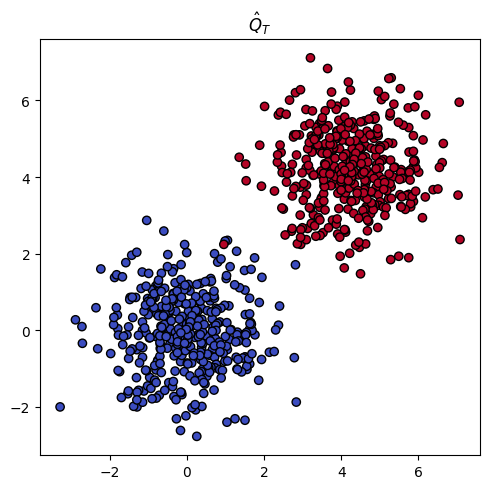

In [96]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

ax.scatter(x=Xt[:, 0], y=Xt[:, 1], c=y, cmap='coolwarm', edgecolor='k')
ax.set_title(r"$\hat{Q}_{T}$")
plt.tight_layout()

## Python implementation of 'ONLINE LEARNING OF GAUSSIAN MIXTURE MODELS: A TWO-LEVEL APPROACH' by Arnaud Declercq, Justus H. Piater

Global Variables

In [97]:
N = len(X)
n_features = 2
precise_fidelity_threshold = 0.95
uncertain_fidelity_threshold = np.exp(N*np.log(precise_fidelity_threshold)/(chi2.ppf(0.05, N-1)))

Utility functions

In [98]:
def initialize_ecdf(x1, x2):
    new_gaussian1 = (x1, np.eye(2), 1)
    new_gaussian2 = (x2, np.eye(2), 1)
    precise_GMM = [new_gaussian1, new_gaussian2]
    uncertain_GMM = [new_gaussian1, new_gaussian2]
    ecdf = ([], [], [])

    for dim in range(len(x1)):
        intervals = ecdf[0]
        intervals.append(np.linspace(np.min((x1[dim], x2[dim])), np.max((x1[dim], x2[dim])), 10))
        populations = ecdf[1]
        populations.append([1, 0, 0, 0, 0, 0, 0, 0, 0, 1])

        ecdf = (intervals, populations, [])

    

    return precise_GMM, uncertain_GMM, ecdf


def ecdf_update(x, ecdf):
    '''
    Update the empirical cumulative distribution function

    params:
      x: new point
      ecdf: empirical cumulative distribution function
    
    return:
      ecdf: (intervals, population, values)
    '''

    intervals = ecdf[0]
    populations = ecdf[1]
    values = []
    for dim in range(len(intervals)):
        n_dim = len(intervals[dim])
        i = 0
        while i < n_dim and x[dim] > intervals[dim][i]:
            i += 1
        if i == 0:
            intervals[dim] = np.linspace(x[dim], intervals[dim][-1], 10)
            populations[dim][0] += 1
        elif i == n_dim:
            intervals[dim] = np.linspace(intervals[dim][0], x[dim], 10)
            populations[dim][-1] += 1
        else:
          populations[dim][i-1] += 1

        Q = np.sum(populations[dim])
        values_added = []
        for i in range(len(intervals[dim])):
            values_added.append(np.sum(populations[:i])/Q)
        values.append(values_added)

    return intervals, populations, values


def ecdf_evaluate(x, ecdf):
    '''
    Evaluate the empirical cumulative distribution function at x

    params:
      x: point
      ecdf: empirical cumulative distribution function
    
    return:
      result: ecdf evaluated at x
    '''

    result = np.zeros(x.shape[0])
    for dim in range(x.shape[0]):
        i = 0
        while i < len(ecdf[0][dim]) and x[dim] > ecdf[0][dim][i]:
            i += 1
        if i == 0:
            result[dim] = 0
        else:
            result[dim] = ecdf[2][dim][i-1]
    
    return result


def tcdf(GMM, x):
    '''
    Compute the value of the theoretical cumulative distribution function of GMM at x
    '''
    result = np.zeros(n_features)
    for dim in range(n_features):
        mass_total = 0
        for i in range(len(GMM)):
            mass_total += GMM[i][2]
            result[dim] +=  GMM[i][2] * norm(GMM[i][0][dim], GMM[i][1][dim, dim]).cdf(x[dim])
        result[dim] /= mass_total

    return result

    

def fidelity(ecdf, GMM, T_D=0.1):
    '''
    Compute the fidelity of the Gaussian model

    params:
      ecdf: empirical cumulative distribution function
      rcdf: theoretical cumulative distribution function
      T_D: allowed deviation parameter

    return: 
      fidelity
    '''

    distance = np.zeros((len(ecdf[0][0]), n_features))
    
    for i in range(len(ecdf[0][0])):
        point = np.zeros(n_features)
        ecdf_values = np.zeros(n_features)
        for dim in range(n_features):
            point[dim] = ecdf[0][dim][i]
            ecdf_values[dim] = ecdf[2][dim][i]
        distance[i, :] = ecdf_values - tcdf(GMM, point)
    distance = np.linalg.norm(distance, axis=0)
    distance =  np.sum(distance) / len(ecdf[0])
    
    fidelity = np.exp(-distance**2/T_D**2)

    return fidelity


def nearest_neighbor(x, L):
    '''
    params:
      x: point of which we search the nearest neighbor
      L: list of points among which we search the nearest neighbor

    return:
      near_point_index: the nearest neighbor index
    '''
    dists= [np.linalg.norm((x, L[i])) for i in range(len(L))]
    near_point_index = np.argmin(dists)

    return near_point_index


def get_nearest_precise_GMM(candidate_index, uncertain_GMM, precise_GMM):
    '''
    params:
      candidate_index: index of the candidate in uncertain_GMM
      uncertain_GMM: uncertain GMM list
      precise_GMM: precise GMM list
    
    return:
      nearest_precise_GMM: indexes of precise GMMs that have the candidate as their nearest neighbor in uncertain_GMM
    '''
    nearest_precise_GMM_indexes = []
    for i in range(len(precise_GMM)):
        near_neighbor_index = nearest_neighbor(precise_GMM[i][0], [uncertain_GMM[j][0] for j in range(len(uncertain_GMM))])
        if near_neighbor_index == candidate_index:
            nearest_precise_GMM_indexes.append(i)
    
    return nearest_precise_GMM_indexes
        

Process functions

In [99]:
def precise_GMM_reduction(GMM, ecdf, threshold):
    simplified = False
    while not simplified:
        if len(GMM) > 1:
            nearest_neighbor_index = nearest_neighbor(GMM[-1][0], [GMM[j][0] for j in range(len(GMM)-1)])
            candidate = GMM[nearest_neighbor_index]

            new_mass = GMM[-1][2] + candidate[2]
            new_mean = 1/new_mass * (GMM[-1][2] * GMM[-1][0] 
                                    + candidate[2] * candidate[0])
            new_cov = GMM[-1][2]/new_mass * (GMM[-1][1] + np.dot((GMM[-1][0] - new_mean).T, (GMM[-1][0] - new_mean))) \
            + candidate[2]/new_mass * (candidate[1] + np.dot((candidate[0] - new_mean).T, (candidate[0] - new_mean)))

            mixed_gaussian = (new_mean, new_cov, new_mass)
            mixed_GMM = GMM.copy()
            del mixed_GMM[-1]
            del mixed_GMM[nearest_neighbor_index]
            mixed_GMM.append(mixed_gaussian)
            
            fidel = fidelity(ecdf, mixed_GMM)
            if fidel > threshold:
                GMM = mixed_GMM
            else:
                simplified = True
        else:
            simplified = True
    return GMM


def uncertain_GMM_reduction(GMM, ecdf, threshold):
    simplified = False
    while not simplified:
        if len(GMM) > 1:
            nearest_neighbor_index = nearest_neighbor(GMM[-1][0], [GMM[j][0] for j in range(len(GMM)-1)])
            candidate = GMM[nearest_neighbor_index]

            new_mass = GMM[-1][2] + candidate[2]
            new_mean = 1/new_mass * (GMM[-1][2] * GMM[-1][0] 
                                    + candidate[2] * candidate[0])
            new_cov = GMM[-1][2]/new_mass * (GMM[-1][1] + np.dot((GMM[-1][0] - new_mean).T, (GMM[-1][0] - new_mean))) \
            + candidate[2]/new_mass * (candidate[1] + np.dot((candidate[0] - new_mean).T, (candidate[0] - new_mean)))

            mixed_gaussian = (new_mean, new_cov, new_mass)
            mixed_GMM = GMM.copy()
            del mixed_GMM[-1]
            del mixed_GMM[nearest_neighbor_index]
            mixed_GMM.append(mixed_gaussian)

            fidel = fidelity(ecdf, mixed_GMM)

            if fidel > threshold:
                GMM = mixed_GMM

            else:
                GMM = uncertain_GMM_reduction(GMM[:-1], ecdf, threshold) + [GMM[-1]]
                simplified = True
        else:
            simplified = True
    return GMM


def uncertain_GMM_process(uncertain_GMM, precise_GMM, ecdf):
    if len(uncertain_GMM) > 1:
        candidate_index = nearest_neighbor(uncertain_GMM[-1][0], [uncertain_GMM[j][0] for j in range(len(uncertain_GMM)-1)])
        candidate = uncertain_GMM[candidate_index] 

        new_mass = uncertain_GMM[-1][2] + candidate[2]
        new_mean = 1/new_mass * (uncertain_GMM[-1][2] * uncertain_GMM[-1][0] 
                                + candidate[2] * candidate[0])
        new_cov = uncertain_GMM[-1][2]/new_mass * (uncertain_GMM[-1][1] + np.dot((uncertain_GMM[-1][0] - new_mean).T, (uncertain_GMM[-1][0] - new_mean))) 
        + candidate[2]/new_mass * (candidate[1] + np.dot((candidate[0] - new_mean).T, (candidate[0] - new_mean)))
        
        mixed_gaussian = (new_mean, new_cov, new_mass)

        mixed_uncertain_GMM = uncertain_GMM.copy()
        del mixed_uncertain_GMM[-1]
        del mixed_uncertain_GMM[candidate_index]
        mixed_uncertain_GMM.append(mixed_gaussian)
        
        fidel = fidelity(ecdf, mixed_uncertain_GMM)
        
        if fidel > uncertain_fidelity_threshold:
            uncertain_GMM = mixed_uncertain_GMM
        else:
            precise_GMM_indexes = get_nearest_precise_GMM(candidate_index, uncertain_GMM, precise_GMM)
            new_precise_GMM = [precise_GMM[i] for i in precise_GMM_indexes] + [uncertain_GMM[-1]]

            new_uncertain_GMM = uncertain_GMM_reduction([precise_GMM[i] for i in precise_GMM_indexes] 
                                                        + [uncertain_GMM[-1]], ecdf, uncertain_fidelity_threshold)
            del uncertain_GMM[candidate_index]
            del uncertain_GMM[-1]
            uncertain_GMM.extend(new_uncertain_GMM)

            new_precise_GMM = precise_GMM_reduction(new_precise_GMM, ecdf, precise_fidelity_threshold)
            precise_GMM_indexes.sort(reverse=True)
            for i in precise_GMM_indexes:
                del precise_GMM[i]
            precise_GMM.extend(new_precise_GMM)

    return uncertain_GMM, precise_GMM

In [100]:
def online_GMM(X):
    n = X.shape[0]
    #stock the different gaussians with format: (mean, covariance, mass)
    precise_GMM, uncertain_GMM, ecdf = initialize_ecdf(X[0], X[1])


    for i in range(2, n):
        ecdf = ecdf_update(X[i], ecdf)
        new_gaussian = (X[i], np.eye(2), 1)
        uncertain_GMM.append(new_gaussian)
        uncertain_GMM, precise_GMM = uncertain_GMM_process(uncertain_GMM, precise_GMM, ecdf)
    
    return uncertain_GMM, precise_GMM

In [101]:
results = online_GMM(Xt.numpy())

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "C:\Users\SL276123\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\interactiveshell.py", line 3526, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\SL276123\AppData\Local\Temp\ipykernel_6732\1457139454.py", line 1, in <module>
    results = online_GMM(Xt.numpy())
              ^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\SL276123\AppData\Local\Temp\ipykernel_6732\2787987015.py", line 11, in online_GMM
    uncertain_GMM, precise_GMM = uncertain_GMM_process(uncertain_GMM, precise_GMM, ecdf)
                                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\SL276123\AppData\Local\Temp\ipykernel_6732\2795170956.py", line 88, in uncertain_GMM_process
    new_uncertain_GMM = uncertain_GMM_reduction([precise_GMM[i] for i in precise_GMM_indexes]
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^